In [1]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# Loss/Cost Function

### The Intuition
In the previous example, we have used the variable `pull` with the value `1` or `-1` to define whether our network parameters (weights and biases) should be pulled towards the positive or the negative direction depending on the label of the current data point. We have seen that over the course of the training, the network gradually improves in classifying our data set. However, this "pull up or down depending on the label" approach does not provide us with a concrete measure that we can use to evaluate how the training is improving. For this reason machine learning uses an additional layer called a *loss function* (also named *cost* function).

#### A Single Data Point
Let's first consider what would be the loss of a neural network which is trained on a single data point: Here, the neural network takes this single data point, for example `[1.2, 0.7]`, all the weights and biases of the neural network, and computes the output. In our case, let's say that the output of the network is `0.63`. A loss function then compares this output with the desired output, defined by the label of that data point. In our case, let's say that the label for this data point is `1`. The difference between these two values `(1.0 - 0.63) = 0.37` defined as *loss* or *cost* shows how good or bad the networks is performing in classifying our data. If the difference between the actual and the desired output is large, the network is performing bad. If this distance is close to zero, (for example if the output was `0.98`, then `(1.0 - 0.98) = 0.02`), the network is performing well. To bring this distance towards zero, we use the backpropagation algorithm just like before, with the additional step of computing the derivative of the loss function itself. <br>


#### Multiple data points
In praxis, to efficiently train a neural network requires a lot of data, not a single data point. In this case we need to compute the *total loss* of a neural network, which means that we need to sum all of the single losses (of all (or some) data points) into a single number, whose value we need to minimize. The goal is to bring this number close to zero __for all__ data points. <br> 
The obstacle to do this is that in the process of backpropagation, we can only compute partial derivatives for a single data point. In order to compute the partial derivatives for all data points, the best we can do is to compute the partials for all the single data points, and then average them into a single _gradient_.

### The quadratic cost function

One of the basic types of loss/cost functions is the __quadratic cost function__. It is also sometimes known as the mean squared error or just MSE. It squares the difference between the label and the output, which makes the loss always a positive value. In our prevous example the quadratic loss would be <br>`(1.0 - 0.63)*(1.0 - 0.63) = 0.1369`. The general form of this function in a neural network would be:

\begin{eqnarray}  C(w,b) \equiv
  \frac{1}{n} \sum_x \| y(x) - a\|^2.
\end{eqnarray}

Here, $w$ denotes the collection of all weights in the network, $b$ all the biases, $n$ is the total number of training inputs, a
$a$ is the vector of outputs from the network when $x$ is input, and the sum is over all training inputs, $x$.

Starting from the previous example

<img src="img/neural_networks_23.png" alt="drawing" width="550"/>

We will implement the same neural network architecture with the added quadratic loss function added at the end. This is how the diagram looks like now:

<img src="img/neural_networks_25.png" alt="drawing" width="750"/>

The only thing that changes with respect to the previous example, is a single additional step in computing a feedforward pass, and a single additional step in computing the derivative $\frac{\partial C}{\partial S}$ of the cost function $C$ in respect to the network's output $S$.

By applying the general formula, the cost of a single training example $(\mathbf{X},\mathbf{Y})$ is 

\begin{align*} 
C_x = (label-S)^2.
\end{align*}

Thus the derivative $\frac{\partial C_x}{\partial S}$ is simply:

\begin{align*}  
\frac{\partial C_x}{\partial S} &= 2*(label - S)\\\\
\end{align*}

Let's implement the algorithm with the same data set. First we will load the display and helper methods:

In [2]:
def eval_accuracy_neural(params, data, labels):
    A1, A2, A3, B1, B2, B3, C1, C2, C3 = params
    num_correct = 0;
    data_len = data.shape[0]
    
    for i in range(data_len):
        X,Y = data[i]
        true_label = labels[i]
        score = circuit_forward(A1, A2, A3, B1, B2, B3, C1, C2, C3, X, Y)
        predicted_label = 1 if score > 0 else -1
        
        if (predicted_label == true_label):
            num_correct += 1
    return num_correct / data_len

def plot_neural_simple(params, grid,data, labels, iteration, accuracy):
    nudge = 0.06
    A1, A2, A3, B1, B2, B3, C1, C2, C3 = params
    xx,yy,Z = grid
    
    for i in range(xx.shape[0]): # row
        for j in range(yy.shape[1]): #column
            X, Y = xx[i][j],yy[i][j]
            score = circuit_forward(A1, A2, A3, B1, B2, B3, C1, C2, C3, X, Y) 
            score = 1 if score > 0 else -1
            Z[i][j] = score
        
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    plt.title(f'accuracy at the iteration {iteration}: {accuracy}')
    ax.contourf(xx, yy, Z, cmap=plt.cm.binary, alpha=0.1, zorder=15)
    ax.scatter(data[:, 0], data[:, 1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    ax.set_aspect('equal')
    for i in range(data.shape[0]):
        d = data[i]
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()
    
def create_meshgrid(data):
    h = 0.02
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return (xx,yy,np.ones(xx.shape))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def circuit_forward(A1,A2,A3,B1,B2,B3,C1,C2,C3,X,Y):
    N1 = sigmoid(A1*X + B1*Y + C1) # 1st neuron
    N2 = sigmoid(A2*X + B2*Y + C2) # 2nd neuron
    S = A3*N1 + B3*N2 + C3 # final activation
    return S

def plot_data(data, labels):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.scatter(data[:,0], data[:,1], c=labels, s=50,  cmap=plt.cm.bwr,zorder=50)
    nudge = 0.08
    for i in range(data.shape[0]):
        d = data[i]
        ax.annotate(f'{i}',(d[0]+nudge,d[1]+nudge))
    ax.set_aspect('equal', 'datalim')
    plt.show()

We will use the same data and labels as before:

In [3]:
data = np.array([[ 1.2, 0.7],
                 [-0.3,-0.5],
                 [ 3.0, 0.1],
                 [-0.1,-1.0],
                 [-0.0, 1.1],
                 [ 2.1,-1.3],
                 [ 3.1,-1.8],
                 [ 1.1,-0.1],
                 [ 1.5,-2.2],
                 [ 4.0,-1.0]])

In [4]:
labels = np.array([ 1,
                    -1,
                     1,
                    -1,
                    -1,
                     1,
                    -1,
                     1,
                    -1,
                    -1])

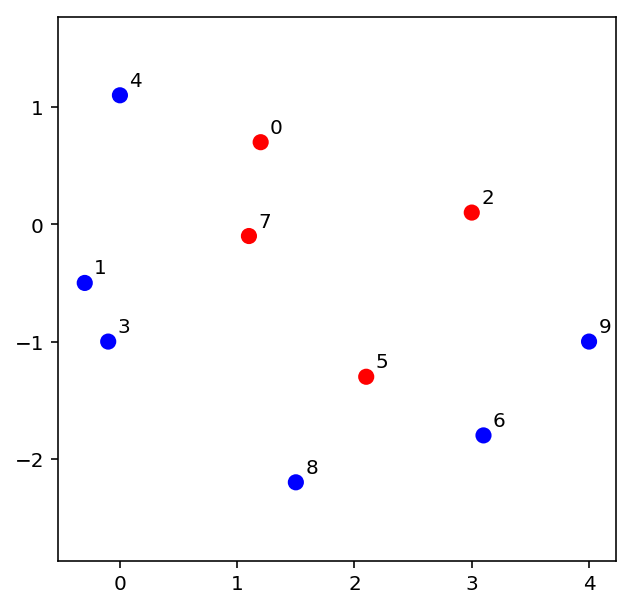

In [5]:
plot_data(data, labels)

This is the training algorithm, much simplified and not-optimised for readability:

In [6]:
def train_neural_network(data, labels, step_size, epochs, iter_info):

    # first we initialise all the weights and biases as normally distributed random numbers
    rnd = np.random.normal(size=9)
    # hidden layer neuron 1
    A1 = rnd[0] #weight for X
    B1 = rnd[1] #weight for Y
    C1 = rnd[2] #bias

    # hidden layer neuron 2
    A2 = rnd[3] #weight for X
    B2 = rnd[4] #weight for Y
    C2 = rnd[5] #bias

    # output layer neuron
    A3 = rnd[6] #weight for n1
    B3 = rnd[7] #weight for n2
    C3 = rnd[8] # bias
    
    grid = create_meshgrid(data)

    # in each epoch, we will go through all the data points once
    for i in range(epochs):
        # total cost must be restarted in every epoch
        total_cost = 0.0
        ddA1, ddA2, ddA3, ddB1, ddB2, ddB3, ddC1, ddC2, ddC3 = 0,0,0,0,0,0,0,0,0
        # here we loop trough all the data points, and get X, Y and the corresponding label
        for index, ((X,Y), label) in enumerate(zip(data, labels)): 
            # forward pass
            N1 = sigmoid(A1*X + B1*Y + C1) # 1st neuron
            N2 = sigmoid(A2*X + B2*Y + C2) # 2nd neuron
            S = A3*N1 + B3*N2 + C3 # final activation
            # This is the implementation of the quadratic cost for the single data point
            cost = (label-S)**2
            # This value is then accumulated into total_cost variable, so that the cost is expressed
            # for all the data points
            total_cost += cost

            # backpropagating through the network
            # here we compute the derivative of the cost C in respect to the network output S
            dS = 2*(label-S)
            # output layer weights and biases are multiplied by dS by using the chain rule
            dA3, dB3, dC3 = dS*N1, dS*N2, dS*1
            
            # The rest of the derivative computation is the same as before:
            
            #second layer activations
            dN1, dN2 = dS*A3, dS*B3

            # intermediate values
            dz1 = dN1 * N1 * (1 - N1)
            dz2 = dN2 * N2 * (1 - N2)

            # second layer neuron 1
            dA1 = dz1*X
            dB1 = dz1*Y
            dC1 = dz1*1

            # second layer neuron 2
            dA2 = dz2*X
            dB2 = dz2*Y
            dC2 = dz2*1
            
            # since we have multiple data points, and we can compute only a single partial derivative at the time
            # we accumulate their values in the variables ddA1...ddC3
            
            ddA1 += dA1
            ddA2 += dA2
            ddA3 += dA3
            ddB1 += dB1
            ddB2 += dB2
            ddB3 += dB3
            ddC1 += dC1
            ddC2 += dC2
            ddC3 += dC3
        
        # Now we make an average of all the accumulated derivatives by dividing with the number of data points
        datalen = len(data)
        ddA1 /= datalen
        ddA2 /= datalen
        ddA3 /= datalen
        ddB1 /= datalen
        ddB2 /= datalen
        ddB3 /= datalen
        ddC1 /= datalen
        ddC2 /= datalen
        ddC3 /= datalen

        # finally, we do the parameter update with the averaged values ddA1...ddC3
        A1 += step_size * ddA1; 
        B1 += step_size * ddB1; 
        C1 += step_size * ddC1;
        A2 += step_size * ddA2; 
        B2 += step_size * ddB2;
        C2 += step_size * ddC2;
        A3 += step_size * ddA3; 
        B3 += step_size * ddB3; 
        C3 += step_size * ddC3;

        if (i%iter_info==0):
            accuracy = eval_accuracy_neural((A1,A2,A3,B1,B2,B3,C1,C2,C3),data,labels)
            plot_neural_simple((A1,A2,A3,B1,B2,B3,C1,C2,C3),grid, data, labels, i, accuracy)
            print (f'total cost: {round(total_cost,4)}\n')
        
    return (A1, A2, A3, B1, B2, B3, C1, C2, C3)

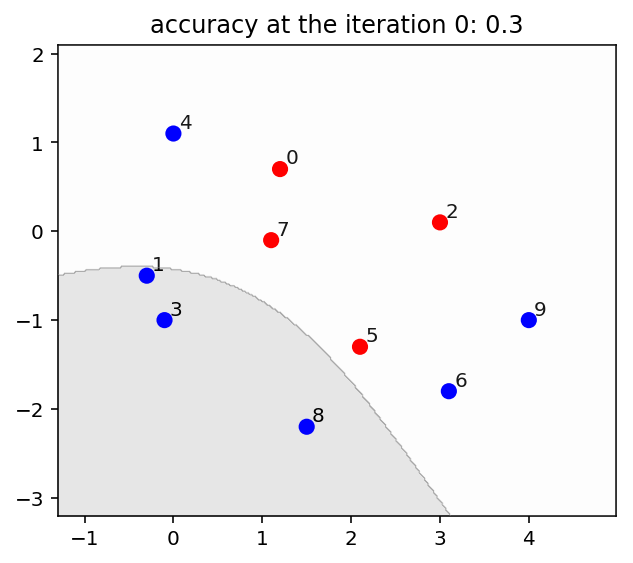

total cost: 31.7531



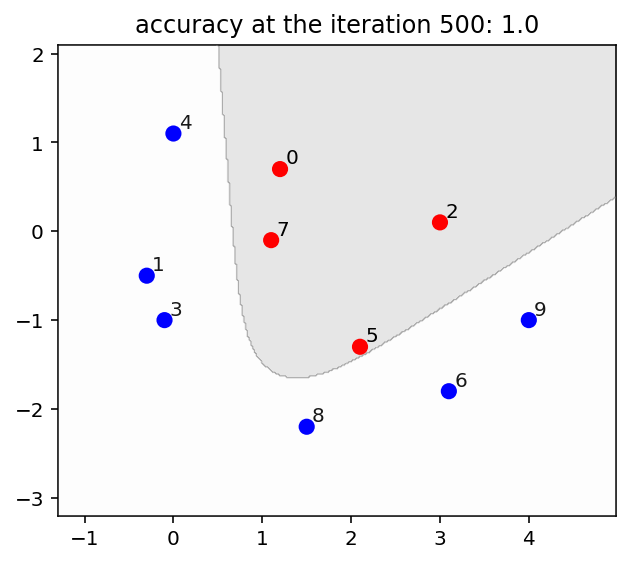

total cost: 0.8756



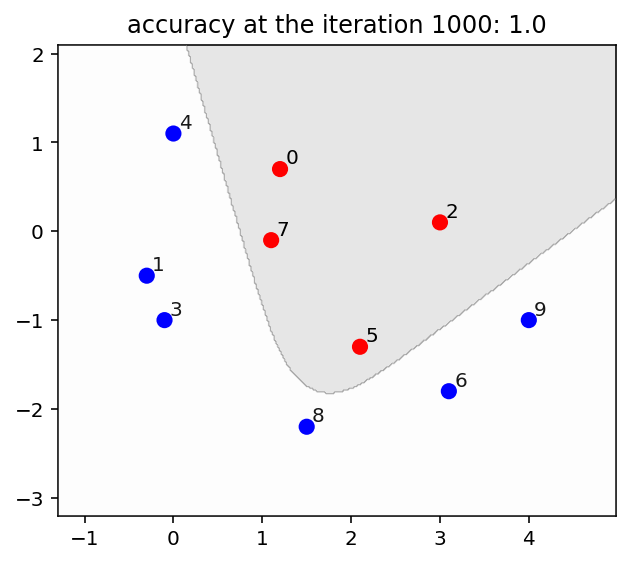

total cost: 0.33



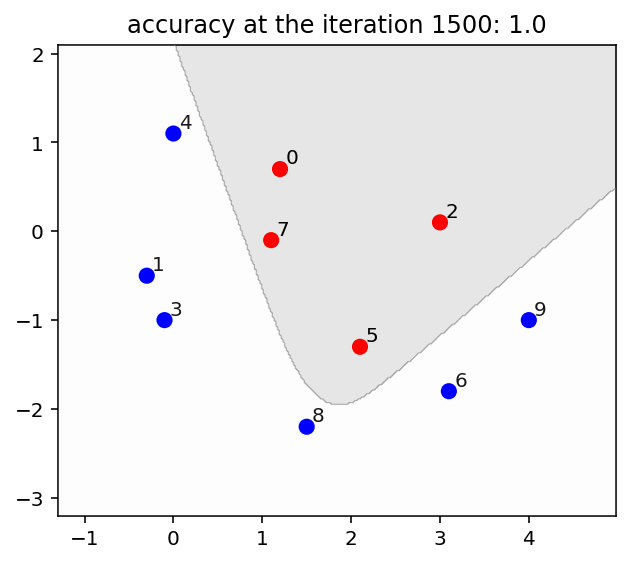

total cost: 0.1912



In [7]:
train = train_neural_network(data, labels, 0.5, 1501, 500)